In [80]:
# simple generative adversarial network
# this version uses a very simple neural network
# aim is to see the adversarial concept working

In [189]:
# conventional PyTorch imports
import torch
import torch.nn as nn
#import torch.nn.functional as F

In [190]:
import random
import pandas

In [191]:
def print_graph(g, level=0):
    if g == None: return
    print('-'*level*4, g)
    for subg in g.next_functions:
        print_graph(subg[0], level+1)

In [192]:
# function to generate real data

def generate_real():
    t = torch.FloatTensor([random.uniform(0.8, 1.0),
                           random.uniform(0.0, 0.2),
                           random.uniform(0.8, 1.0),
                           random.uniform(0.0, 0.2)]).view(1, 4)
    return t

In [193]:
# function to generate false data

def generate_false():
    t = torch.FloatTensor([random.uniform(0.0, 0.2),
                           random.uniform(0.8, 1.0),
                           random.uniform(0.0, 0.2),
                           random.uniform(0.8, 1.0)]).view(1, 4)
    return t

In [194]:
# function to generate unfirom random data

def generate_random():
    t = torch.FloatTensor([random.uniform(0.0, 1.0),
                           random.uniform(0.0, 1.0),
                           random.uniform(0.0, 1.0),
                           random.uniform(0.0, 1.0)]).view(1, 4)
    return t

In [195]:
print(generate_false())
print(generate_real())
print(generate_random())

tensor([[0.1907, 0.8207, 0.0271, 0.8904]])
tensor([[0.9146, 0.1860, 0.9781, 0.1110]])
tensor([[0.2791, 0.2557, 0.4033, 0.3993]])


In [255]:
# disciminitator
# inherits from pytorch's neural network


class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define the layers and their sizes, turn off bias
        self.linear_ih = nn.Linear(4, 3, bias=False)
        self.linear_ho = nn.Linear(3, 1, bias=False)
        
        # define activation function
        self.activation = nn.Sigmoid()
        
        # create error function
        self.error_function = torch.nn.MSELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # accumulator for progress
        self.progress = []
        pass
    
    def forward(self, inputs):        
        # combine input layer signals into hidden layer
        hidden_inputs = self.linear_ih(inputs)
        # apply sigmiod activation function
        hidden_outputs = self.activation(hidden_inputs)
        
        # combine hidden layer signals into output layer
        final_inputs = self.linear_ho(hidden_outputs)
        # apply sigmiod activation function
        final_outputs = self.activation(final_inputs)
        
        # debug
        #print("==== D ====")
        #print_graph(final_outputs.grad_fn, 0)
        
        return final_outputs
    
    def train(self, inputs, targets):
        # calculate the output of the network
        output = self.forward(inputs)
        
        # calculate error
        loss = self.error_function(output, targets)
        
        # accumulate error
        self.progress.append(loss.item())

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 0.5), figsize=(16,8), alpha=0.1, marker='.')
        pass
    
    pass

In [256]:
D = Discriminator()

D.forward(generate_real())

tensor([[0.4939]], grad_fn=<SigmoidBackward>)

In [264]:
D = Discriminator()

for i in range(10000):
    D.train(generate_real(), torch.FloatTensor([1.0]))
    D.train(generate_false(), torch.FloatTensor([0.0]))
    #D.train(generate_random(), torch.FloatTensor([1.0]))
    #D.train(generate_random(), torch.FloatTensor([0.0]))
    pass


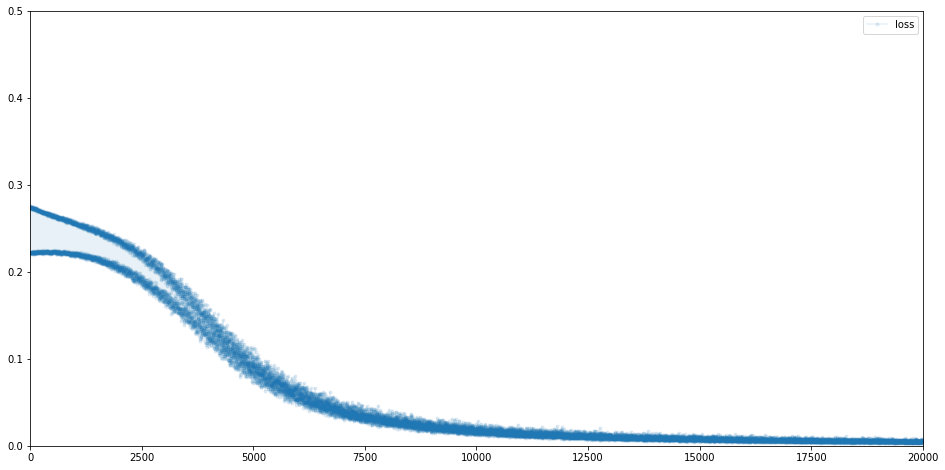

In [265]:
D.plot_progress()

In [261]:
print( D.forward(torch.FloatTensor([0.0, 1.0, 0.0, 1.0])).item() )
print( D.forward( torch.FloatTensor([1.0, 0.0, 1.0, 0.0])).item() )

0.055216994136571884
0.9464666843414307


In [266]:
# generator
# inherits from pytorch's neural network


class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define the layers and their sizes, turn off bias
        self.linear_ih = nn.Linear(4, 4, bias=False)
        self.linear_ho = nn.Linear(4, 4, bias=False)
        
        # define activation function
        self.activation = nn.Sigmoid()
        
        # create error function
        self.error_function = torch.nn.MSELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # accumulator for progress
        self.progress = []
        pass
    
    def forward(self, inputs):        
        # combine input layer signals into hidden layer
        hidden_inputs = self.linear_ih(inputs)
        # apply sigmiod activation function
        hidden_outputs = self.activation(hidden_inputs)
        
        # combine hidden layer signals into output layer
        final_inputs = self.linear_ho(hidden_outputs)
        # apply sigmiod activation function
        final_outputs = self.activation(final_inputs)
        
        # debug
        #print("==== G ====")
        #print_graph(final_outputs.grad_fn, 0)
        
        return final_outputs
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = self.error_function(d_output, targets)
        
        # accumulate error
        self.progress.append(loss.item())

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 0.5), figsize=(16,8), alpha=0.1, marker='.')
        pass
    
    pass

In [283]:
# create Discriminator and Generator

D = Discriminator()
G = Generator()


# train Discriminator and Generator

for i in range(10000):
    
    # train discriminator on true
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # train discriminator on false
    D.train(G.forward(generate_random()).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random(), torch.FloatTensor([1.0]))
    
    pass

In [284]:
print( D.forward(generate_real()).item() )
print( D.forward(generate_false()).item() )

0.46033281087875366
0.06154390797019005


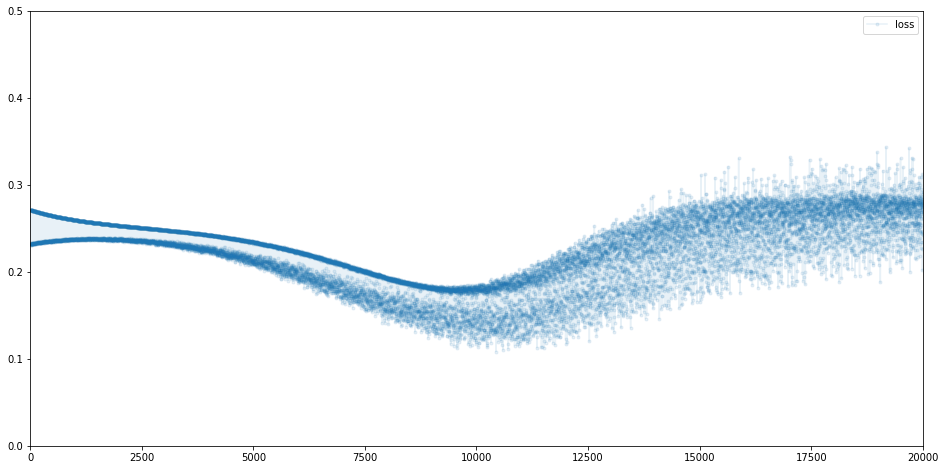

In [285]:
D.plot_progress()

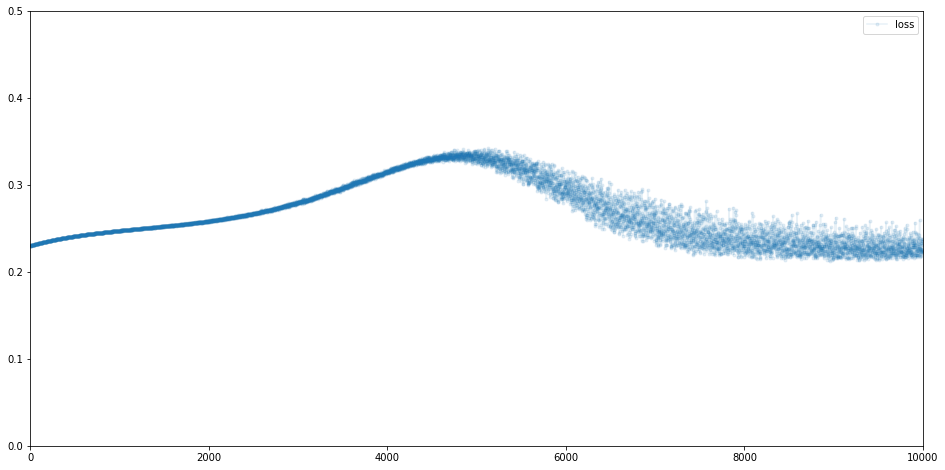

In [286]:
G.plot_progress()

In [287]:
print(G.forward(generate_random()))
print(G.forward(generate_random()))
print(G.forward(generate_random()))
print(G.forward(generate_random()))

tensor([[0.9127, 0.0312, 0.9322, 0.0315]], grad_fn=<SigmoidBackward>)
tensor([[0.9174, 0.0288, 0.9380, 0.0289]], grad_fn=<SigmoidBackward>)
tensor([[0.8855, 0.0526, 0.9030, 0.0534]], grad_fn=<SigmoidBackward>)
tensor([[0.8956, 0.0441, 0.9150, 0.0442]], grad_fn=<SigmoidBackward>)
